In [115]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import skimage

%matplotlib inline

In [116]:
N_PTS = 50

In [117]:
def tangle(points, weights=0.01, steps=1, normalize=True):
    for s in range(steps):
        diff = np.diff(points, axis=0)
        current_length = np.linalg.norm(diff, axis=-1)
        #target_length = np.mean(current_length) * 1.01
        #length_error = current_length - target_length
        curve = np.diff(diff, axis=0) * 0.1
        curve_right = curve - (np.sum(curve * diff[1:], axis=-1) / current_length[1:])[:, None] * diff[1:]
        curve_left = curve - (np.sum(curve * diff[:-1], axis=-1) / current_length[:-1])[:, None] * diff[:-1]
        sqr_dist = np.sum(diff * diff, axis=-1, keepdims=True)
        diff2 = points[2:] - points[:-2]
        sqr_dist2 = np.sum(diff2 * diff2, axis=-1, keepdims=True)
        if normalize:
            sqr_dist /= np.mean(sqr_dist)
            sqr_dist2 /= np.mean(sqr_dist2)
        diff2 /= sqr_dist2

        # Adjust length
        force = np.zeros_like(points)
        #length_force = length_error[:, None] * diff / current_length[:, None]
        force[:len(diff)] = diff #-length_force
        force[1:] -= diff #length_force

        # Repel from points 2 away
        # force[:len(diff2)] -= diff2
        # force[2:] += diff2

        # Straighten bends
        force[:len(curve)] -= curve_left
        force[2:] -= curve_right

        # force[:len(diff) - 1] -= diff1[1:]
        # force[2:] += diff1[:-1]

        # force *= 0.5
        
        points = points + weights * force
    return points

def tangle_2(points, weights=0.0001, steps=1):
    for s in range(steps):
        sqr_distance_matrix = points @ points.T
        mean_dist = np.mean(sqr_distance_matrix)
        np.fill_diagonal(sqr_distance_matrix, np.inf)
        pairwise_diff = (points[None] - points[:, None]) * 0.001

        forces = -np.sum(pairwise_diff * mean_dist / sqr_distance_matrix[..., None], axis=1)

        diff = np.diff(points, axis=0)
        forces[:len(diff)] += diff
        forces[1:] -= diff

        points = points + weights * forces
    return points

In [118]:
def generate():
    points = np.random.uniform(-1, 1, (N_PTS, 3))
    points[0] = np.array([-1, 0, 0])
    points[-1] = np.array([1, 0, 0])
    points[1] = np.array([-0.98, 0, 0])
    points[-2] = np.array([0.98, 0, 0])
    points[:, 2] *= 0.75
    points[:, 2] += 1
    
    weights = np.full((N_PTS, 1), 0.2)
    weights[0] = 0
    weights[-1] = 0
    tangled_pts = tangle(points, weights, steps=100)
    return tangled_pts

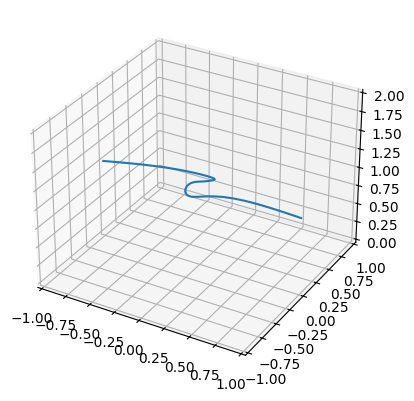

In [119]:
tangled_pts = generate()
ax = plt.figure().add_subplot(projection='3d')
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(0, 2)
# ax.scatter(*tangled_pts.T)
ax.plot(*tangled_pts.T)

In [120]:
def skew(vecs):
    zeros = np.zeros(vecs.shape[:-1])
    arr = np.array([[        zeros, -vecs[..., 2],  vecs[..., 1]],
                    [ vecs[..., 2],         zeros, -vecs[..., 0]],
                    [-vecs[..., 1],  vecs[..., 0],         zeros]])
    # (3, 3, *batch)
    return np.moveaxis(arr, (0, 1), (-2, -1))

In [121]:
WIDTH = 640
HEIGHT = 480

CAMERA_POS = np.array([[0,   0,   0],
                       [0.5, 0,   0],
                       [0,   0.5, 0]])
CAMERA_ROT = np.repeat(np.eye(3)[None], 3, 0)
# CAMERA_INT = np.array([[WIDTH,      0,  WIDTH / 2],
#                        [    0, HEIGHT, HEIGHT / 2],
#                        [    0,      0,          1]])
ESSENTIALS = skew(-CAMERA_POS) @ CAMERA_ROT.swapaxes(-2, -1)
PROJECTION = np.concatenate((CAMERA_ROT.swapaxes(-2, -1), -CAMERA_POS[..., None]), axis=-1)

CAMERA_INT = np.eye(3)

def project(points, p_matrix):
    local_pts = p_matrix[:, None] @ points[..., None]
    return local_pts[..., 0] / local_pts[..., 2:, 0]

def draw(points):
    canvas = np.ones((HEIGHT, WIDTH))
    points = points.astype(int)
    for i in range(len(points) - 1):
        rr, cc = skimage.draw.line(points[i][1], points[i][0], points[i+1][1], points[i+1][0])
        canvas[rr, cc] = 0
    dist = sp.ndimage.distance_transform_edt(canvas)
    grad_x = np.diff(dist, axis=1)
    grad_y = np.diff(dist, axis=0)
    return points, canvas, dist, grad_x, grad_y

# def optimize(points, grad_x, grad_y, weights=1, steps=100):
#     for s in range(steps):
#         force = np.zeros_like(points)

#         for c in range(3):
#             grads_x = sample_bilinear(grad_x[c], points)
#             grads_y = sample_bilinear(grad_y[c], points)
#             grads = np.stack((grads_x, grads_y), axis=-1)
#             force -= weights * grads

#             diff = np.diff(points, axis=0)
#             sqr_mag = np.sum(diff * diff, axis=-1, keepdims=True)
#             diff = diff / sqr_mag
            
#             force[:len(diff)] += diff
#             force[1:] -= diff

#         points = points + force

#         points += np.random.normal(0, 10 / (s + 1), points.shape)
#         points = np.clip(points, np.zeros(2), np.array((WIDTH, HEIGHT)))
#     return points

In [122]:
def intersect_curves(epipolar_lines, points_h_2d):
    offsets = np.einsum('ijl,ikl->ijk', epipolar_lines, points_h_2d) #np.sum(epipolar_lines[:, :, None] * points_h_2d[:, None], axis=-1) # (c, n1, 1, 3) * (c, 1, n2, 3)
    sgn = np.sign(offsets)
    flip = sgn[..., 1:] - sgn[..., :-1]
    cc, n1, n2 = np.nonzero(flip)
    # Todo: handle multiple cameras (different number of intersects)
    diff = points_h_2d[cc, n2] - points_h_2d[cc, n2 + 1]
    rate = np.sum(epipolar_lines[cc, n1] * diff, axis=-1)
    factor = (-offsets[cc, n1, n2] / rate)[..., None]
    rate_normalized = rate / (np.linalg.norm(epipolar_lines[cc, n1], axis=-1) * np.linalg.norm(diff, axis=-1))
    return points_h_2d[cc, n2] + factor * diff, rate_normalized, cc, n1

# def pick_candidates(intersections):
    # pick candidates based on proximity and curvature to previous points

    # pass

MovieWriter ffmpeg unavailable; using Pillow instead.


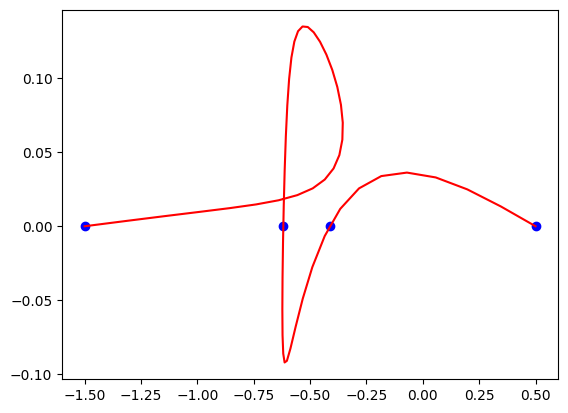

In [123]:
tangled_pts_h = np.concatenate((tangled_pts, np.ones((50, 1))), axis=-1)
points_2d_h = project(tangled_pts_h, PROJECTION)

last_depths = []
last_point = None
all_depths = []

e = ESSENTIALS[1:] 
p = PROJECTION[1:]

epipolar_lines = (e[:, None] @ points_2d_h[0, ..., None])[..., 0]
assert epipolar_lines.shape == (2, N_PTS, 3)
intersections, rate_normalized, cc, n1 = intersect_curves(epipolar_lines, points_2d_h[1:])
assert intersections.shape == cc.shape + (3,)

fig = plt.figure()  
   
# marking the x-axis and y-axis 
axis = plt.axes()  
  
# initializing a line variable 
line, = axis.plot(*points_2d_h[1, ..., :2].T, color='red') 
scatter = axis.scatter(*intersections[cc==0][..., :2].T, color='blue') 

def animate(i):
    scatter.set_offsets(intersections[np.logical_and(cc==0, n1==int(i))][..., :2])
    return [scatter]

from matplotlib.animation import FuncAnimation
anim = FuncAnimation(fig, animate,
                     frames = N_PTS, interval = 200, blit = True) 
anim.save('intersections.gif')
# candidates = ...
# depths = pick_candidates(last_depths, candidates, n=2)
# all_depths.append(depths)

# points_img, img, dist, grad_x, grad_y = zip(*[draw(points_2d_h[:, i]) for i in range(3)])

# starting_points = np.stack((np.linspace(0, 639, 100), np.zeros(100), np.zeros(100)), axis=-1)

# weights = np.full((100, 1), 1)
# weights[0] = 0
# weights[-1] = 0

# optimized = optimize(starting_points, grad_x, grad_y, weights)

# plt.plot(*optimized.T, color='blue')
# plt.scatter(*points_img.T, color='red')

In [124]:
def get_depths(points1_matched, intersections, transformation):
    # get ray directions of matching points
    global_pts2 = (transformation[..., :3] @ intersections[..., None])[..., 0]
    # get other camera origin (same as ray origin of matching points)
    translation = transformation[None, ..., 3]
    # find perpendicular displacement from origin to each ray
    # by subtracting projection of translation onto ray
    # print(translation.shape, global_pts2.shape)
    projection = (np.sum(translation * global_pts2, axis=-1, keepdims=True)
                                   / np.sum(global_pts2 * global_pts2, axis=-1, keepdims=True)) * global_pts2
    # print(projection.shape)
    perpendicular = translation - projection
    # find depths as length of perpendiculars divided by component of first camera rays on perpendiculars
    # basically, rays cast from camera 1 origin should reach the ray cast from camera 2
    # print(translation, global_pts2)
    # print(points1_matched, projection)
    return np.sum(perpendicular * perpendicular, axis=-1) / np.sum(points1_matched * perpendicular, axis=-1)

In [125]:
TRANSFORMATION = np.concatenate((CAMERA_ROT, CAMERA_POS[..., None]), axis=-1)
matches_1 = n1[cc==0]
depths_1 = get_depths(points_2d_h[0][matches_1], intersections[cc==0], TRANSFORMATION[1])
pos_1 = depths_1 > 0
split_idx_1 = np.unique(matches_1[pos_1], return_index=True)[1][1:]
corres_1 = np.split(depths_1[pos_1], split_idx_1)
assert all([all(c > 0) for c in corres_1])

matches_2 = n1[cc==1]
depths_2 = get_depths(points_2d_h[0][matches_2], intersections[cc==1], TRANSFORMATION[2])
pos_2 = depths_2 > 0
split_idx_2 = np.unique(matches_2[pos_2], return_index=True)[1][1:]
corres_2 = np.split(depths_2[pos_2], split_idx_2)
assert all([all(c > 0) for c in corres_2])

err = [c1[..., None] - c2[..., None, :] for c1, c2 in zip(corres_1, corres_2)]
assert len(err) == len(points_2d_h[0])
assert len(err) == N_PTS

In [126]:
# TODO: pick multiple possible accepted depths and do beam search
# DEPTH_THRESHOLD = 0.02
# todo: use variable threshold based on rate
# accept = [er < DEPTH_THRESHOLD for er in err]
accept = [np.argmin(np.abs(er)) for er in err]
idx = np.array([np.unravel_index(acc, er.shape) for acc, er in zip(accept, err)])
depths = np.array([0.5 * (corres_1[i][idx[i, 0]] + corres_2[i][idx[i, 1]]) for i in range(N_PTS)])
points_3d = points_2d_h[0] * depths[..., None]

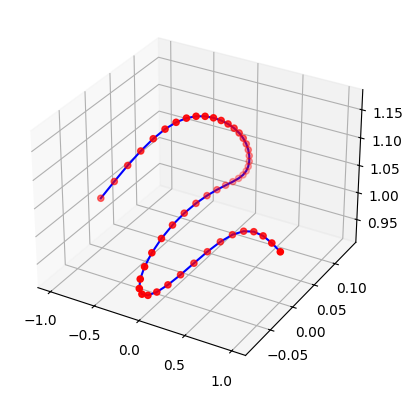

In [129]:
ax = plt.figure().add_subplot(projection='3d')
# ax.set_xlim3d(-1, 1)
# ax.set_ylim3d(-1, 1)
# ax.set_zlim3d(0, 2)
# ax.scatter(*tangled_pts.T)

ax.plot(*tangled_pts.T, color='blue')
ax.scatter(*points_3d.T, color='red')